In [1]:
import os 

os.environ["KERAS_BACKEND"] = "torch"

from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import einops
from keras import ops

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



max_length = 16
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams, "output_attentions":True}
def predict_step(image_paths):
  images = []
  for image_path in image_paths:
    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
      i_image = i_image.convert(mode="RGB")

    images.append(i_image)

  pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
  pixel_values = pixel_values.to(device)

  output_ids = model.generate(pixel_values, **gen_kwargs)

  preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
  preds = [pred.strip() for pred in preds]
  return preds

def preprocess_vit(image_path):
  image = Image.open(image_path)
  image = image.convert(mode="RGB")
  pixel_values = processor(images=image, return_tensors="pt").pixel_values
  pixel_values = pixel_values.to(device)

  return pixel_values

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "pytorch"

import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import einops
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration, Blip2Processor, Blip2ForConditionalGeneration


processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
tokenizer = processor.tokenizer
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 

In [15]:
image_path = "./test_images/dance 2.bmp"
image = Image.open(image_path)
image = image.convert(mode="RGB")

# inputs = processor(raw_image, return_tensors="pt")

pixel_values = processor(images=image, return_tensors="pt").pixel_values
pixel_values = pixel_values.to(device)

# BLIP

In [ ]:
output_ids = model.generate(pixel_values, **gen_kwargs)
tokenizer.batch_decode(output_ids)

In [ ]:
def top_k_sample(top_k_logits, temperature=1.0):
    """
    Perform top-k sampling with temperature on the top-k logits.

    Parameters:
    - top_k_logits: A 1D numpy array representing the top-k logits.
    - temperature: A parameter controlling the level of randomness in sampling.

    Returns:
    - A sampled index.
    """

    # Apply temperature to the logits
    logits_with_temperature = top_k_logits / temperature

    # Compute softmax to get probabilities
    probabilities = np.exp(logits_with_temperature - np.max(logits_with_temperature))
    probabilities /= np.sum(probabilities)

    # Sample from the top-k probabilities
    sampled_index = np.random.choice(np.arange(len(top_k_logits)), p=probabilities)

    return sampled_index


In [ ]:
def beam_search(input_ids, pixel_values, model_fn, stop_token_id=None, beam_width=5, max_len=50, temperature=1.0, look_back_length=5):
    """
    Performs beam search sampling on an LLM, with early stopping on encountering a specific token ID.

    Args:
        input_ids: List of integer IDs for the initial input sequence.
        pixel_values: (Optional) Pixel values to incorporate into the model prediction.
        model_fn: Function that takes input_ids, pixel_values (if provided), and returns logits for next token.
        stop_token_id: Integer ID of the token that triggers early stopping (optional).
        beam_width: Number of beams to keep at each step.
        max_len: Maximum length of the generated sequence.
        temperature: Controls the exploration-exploitation trade-off.

    Returns:
        best_sequence: List of integer IDs for the best generated sequence.
        best_score: Score of the best generated sequence.
        attention_weights: (Optional) List of attention weights for each step, if supported by the model.
    """

    # Initialize beams
    breams = [(input_ids, 1)]
    


    beams = [(input_ids, 0.0, [])]
    attention_weights = []

    # Iterate until max_len reached or all beams have finished
    for _ in tqdm(range(max_len)):
        all_beams = []
        for beam_idx, (current_ids, score, attention_weights_step) in enumerate(beams):

            # Check if all sequences have already stopped
            if all(next_id == stop_token_id for next_id in current_ids):
                continue

            # Get logits for next token
            logits, attention_weights_outputs = model_fn(current_ids, pixel_values)

            # Early stopping check
            if stop_token_id is not None and stop_token_id in logits:
                best_sequence = current_ids + [stop_token_id]
                best_score = score - np.log(logits[stop_token_id])
                return best_sequence, best_score, attention_weights

            # Update attention weights
            attention_weights.extend(attention_weights_outputs)

            # Apply temperature
            if temperature > 0:
                probs = np.exp(logits / temperature) / np.sum(np.exp(logits / temperature))
            else:
                probs = logits

            # Expand each beam
            topk = torch.topk(torch.tensor(probs), beam_width)
            top_k_probs, top_k_indices = topk.values.numpy(), topk.indices.numpy()

            for k in range(beam_width):
                next_id = top_k_indices[k]
                next_score = score - np.log(top_k_probs[k])
                next_ids = current_ids + [next_id]
                next_attention_weights = attention_weights_step + [attention_weights_outputs]  # Update attention weights
                all_beams.append((next_ids, next_score, next_attention_weights))

        # Prune beams
        beams = sorted(all_beams, key=lambda x: x[1], reverse=True)[:beam_width]

    # Return best beam
    # best_sequence, best_score = beams[0]
    best_sequence, _, _ = beams[0]
        
    return best_sequence, attention_weights

In [16]:
input_start_token = tokenizer("<|endoftext|>", return_tensors='pt')
input_ids = input_start_token['input_ids'].to('cuda')
attention_mask = input_start_token['attention_mask'].to('cuda')

In [ ]:
def topk_items_indices(array, k):
    # Get the indices of the top-k items
    indices = np.argpartition(array, -k)[-k:]
    # Get the top-k items
    items = array[indices]
    # Return as a tuple
    return items, indices

In [17]:
def model_function(input_ids, pixel_values):
    with torch.no_grad():
        outputs = model(pixel_values, torch.tensor([input_ids]).cuda(), output_attentions=True)
        cross_attention = outputs.cross_attentions
        encoder_attention = outputs.encoder_attentions
        decoder_attention = outputs.decoder_attentions
        logits = torch.squeeze(outputs.logits[-1, -1].cpu()).numpy()

    return logits, cross_attention, encoder_attention, decoder_attention#[-1].cpu()

### Greedy

In [18]:
sampled_ids = input_ids.cpu().numpy().tolist()[0]
start_length = len(sampled_ids)
max_length = 20
attention_weights = {
    "cross_attention": [],
    "encoder_attention": [],
    "decoder_attention": []
}

while len(sampled_ids) <= max_length+start_length:
    logits, cross_attention, encoder_attention, decoder_attention = model_function(sampled_ids, pixel_values)
    probs = np.exp(logits) / np.sum(np.exp(logits))

    sampled_idx = np.argmax(probs)

    attention_weights['cross_attention'].append(np.array([item.cpu().numpy()[0] for item in cross_attention]))
    attention_weights['encoder_attention'].append(np.array([item.cpu().numpy()[0] for item in encoder_attention]))
    attention_weights['decoder_attention'].append(np.array([item.cpu().numpy()[0] for item in decoder_attention]))

    sampled_ids.append(sampled_idx)

    print(tokenizer.decode(sampled_ids), end='\r')

    if sampled_idx == 50256:
        break
    
# attention_weights = np.array(attention_weights)
    

/tmp/ipykernel_1466/534762024.py:12: RuntimeWarning: invalid value encountered in divide
  probs = np.exp(logits) / np.sum(np.exp(logits))


In [ ]:
sampled_ids = input_ids.cpu().numpy().tolist()[0]
start_length = len(sampled_ids)
sequence_length = 20
attention_weights = []

while len(sampled_ids) <= max_length+start_length:
    with torch.no_grad():
        outputs = model(pixel_values, torch.tensor([sampled_ids]).cuda(), output_attentions=True)
        cross_attention = outputs.cross_attentions
        encoder_attention = outputs.encoder_attentions
        decoder_attention = outputs.decoder_attentions
        logits = torch.squeeze(outputs.logits.cpu()).numpy()


    attention_weights.append(cross_attention[-1].cpu())
    topk = torch.topk(torch.tensor(logits), k=500)
    if len(topk.values.shape) > 1:
        top_k_logits = topk.values.numpy()[0]
        top_k_indices = topk.indices.numpy()[0]
    else:
        top_k_logits = topk.values.numpy()
        top_k_indices = topk.indices.numpy()
    # top_k_logits, top_k_indices = topk_items_indices(logits, 500)
    sampled = top_k_indices[top_k_sample(top_k_logits, temperature=0.2)]
    if sampled_idx == 50256:
        break
    sampled_ids.append(sampled)

    print(tokenizer.decode(sampled_ids), end='\r')

In [ ]:
(len(sampled)//4)+1

In [ ]:
attention_weights['cross_attention'][7][-1, -1].shape

In [ ]:
sampled_ids

In [ ]:
len(attention_weights['cross_attention'])

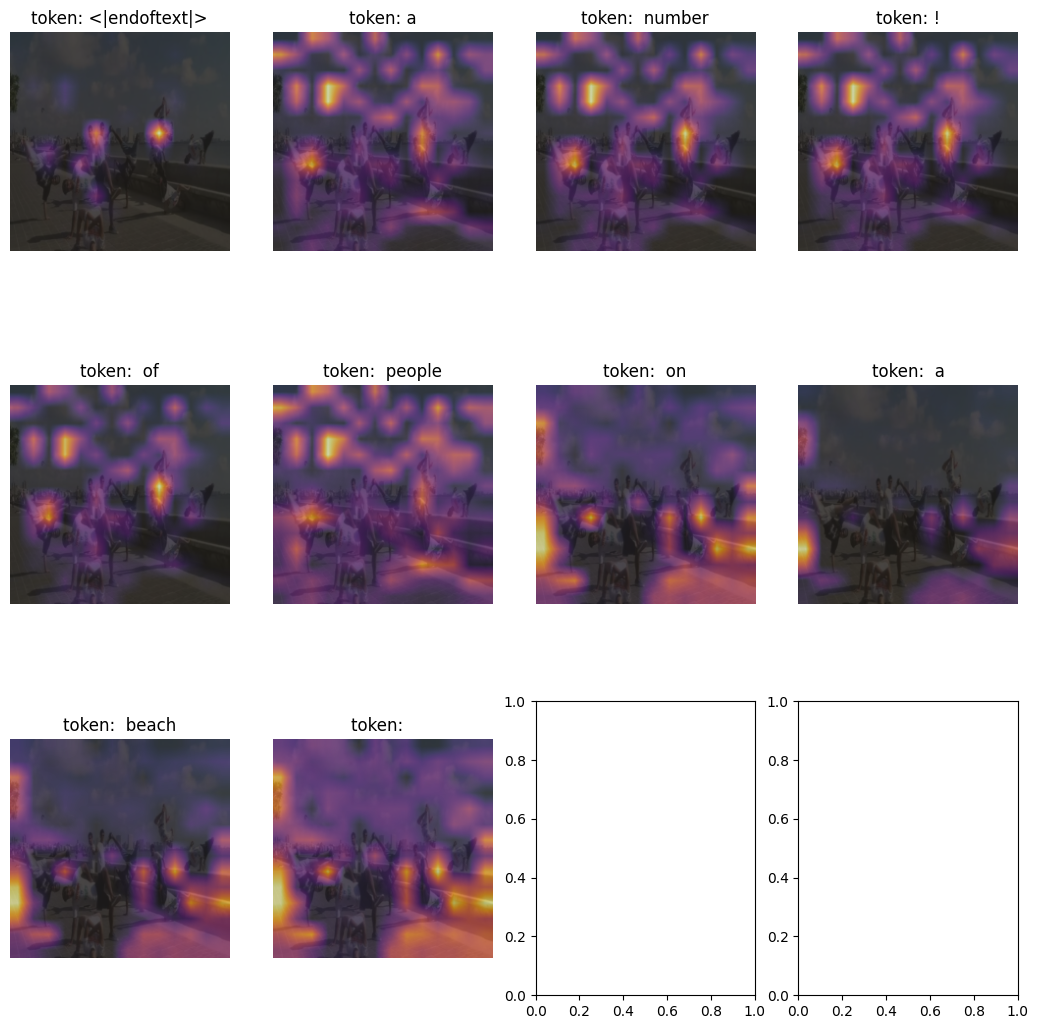

In [19]:
# test_idx = 5
# sampled = sampled_ids[1:]
# token = sampled[test_idx]
# token_value = tokenizer.decode(token)

patch_size = 16
w_featmap = 224 // patch_size
h_featmap = 224 // patch_size
num_heads = 12

# attention_scores = attention_weights[test_idx][-1, :, 1, 1:] # [last layer, all heads, first context token, ignore cls]
# attention_scores = np.reshape(attention_scores, (num_heads, w_featmap, h_featmap))
# attention_scores = np.transpose(attention_scores, (1, 2, 0))
# attention_scores = ops.image.resize(attention_scores, size=(h_featmap * patch_size, w_featmap * patch_size)).cpu().numpy()

# # De-normalize the image for visual clarity.
in1k_mean = np.array([0.485 * 255, 0.456 * 255, 0.406 * 255]) # image darking filters
in1k_std = np.array([0.229 * 255, 0.224 * 255, 0.225 * 255])

image_np = np.transpose(pixel_values.cpu().numpy()[0], (1, 2, 0))

preprocessed_img_orig = (image_np * in1k_std) + in1k_mean
preprocessed_img_orig = preprocessed_img_orig / 255.0
preprocessed_img_orig = ops.convert_to_numpy(ops.clip(preprocessed_img_orig, 0.0, 1.0))

# Plot the maps.
# n_cols = 4
# n_rows = (len(sampled)//4)+1
# fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(13, 13))
# img_count = 0

# for i in range(3):
#     for j in range(4):
#         if img_count < len(attention_scores):
#             axes[i, j].imshow(preprocessed_img_orig)
#             axes[i, j].imshow(attention_scores[..., img_count], cmap="inferno", alpha=0.6)
#             axes[i, j].title.set_text(f"Attention head: {img_count}\ntoken: {token_value}")
#             axes[i, j].axis("off")
#             img_count += 1



n_cols = 4
n_rows = (len(sampled_ids)//4)+1
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(13, 13))
token_count = 0

for i in range(n_rows):
    for j in range(n_cols):
        if token_count < len(sampled_ids)- 1:
            token = sampled_ids[token_count]
            token_value = tokenizer.decode(token)

            attention_scores = attention_weights['cross_attention'][token_count][-1, :, -1, 1:] # [last layer, all heads, first context token, ignore cls]
            attention_scores = np.reshape(attention_scores, (num_heads, w_featmap, h_featmap))
            attention_scores = np.transpose(attention_scores, (1, 2, 0))
            attention_scores = ops.image.resize(attention_scores, size=(h_featmap * patch_size, w_featmap * patch_size)).cpu().numpy()
            average_attention_over_heads = np.mean(attention_scores, axis=-1)

            axes[i, j].imshow(preprocessed_img_orig)
            axes[i, j].imshow(average_attention_over_heads, cmap="inferno", alpha=0.6)
            axes[i, j].title.set_text(f"token: {token_value}")
            axes[i, j].axis("off")
            token_count += 1

# plt.imshow(preprocessed_img_orig)
# plt.imshow(np.mean(attention_scores, axis=-1), cmap="inferno", alpha=0.6)
# plt.title(f"token: {token_value}")
# plt.axis("off")
# plt.show()

In [ ]:
attention_scores = attention_weights['cross_attention'][4][-1, :, 0, 1:]
attention_scores = np.reshape(attention_scores, (num_heads, w_featmap, h_featmap))
attention_scores = np.mean(attention_scores, axis=0)

In [ ]:
attention_scores.shape

In [ ]:
plt.figure(figsize=(4, 4))
plt.imshow(attention_scores, interpolation=None, cmap='inferno')
plt.show()


In [ ]:
def square_crop(image, n):
    """
    Squares an image by cropping n pixels from each side.

    Args:
        image: The PIL.Image object to be cropped.
        n: The number of pixels to crop from each side (left, right, top, bottom).

    Returns:
        A new PIL.Image object with a square crop.
    """
    width, height = image.size
    # Get the minimum dimension to ensure a square crop
    crop_size = min(width - 2 * n, height - 2 * n)

    # Handle cases where the image is already square or smaller than desired crop size
    if crop_size <= 0:
        return image.copy()  # Return a copy of the original image

    # Calculate the top-left corner of the square crop
    left = (width - crop_size) // 2
    top = (height - crop_size) // 2

    # Create the crop box (left, top, right, bottom)
    box = (left, top, left + crop_size, top + crop_size)

    # Crop the image and return the new square image
    return image.crop(box)

    # Example usage
    image = Image.open("path/to/your/image.jpg")
    cropped_image = square_crop(image, 10)  # Crop 10 pixels from each side
    cropped_image.show()  # Display the cropped image

In [ ]:
square_crop=

In [ ]:
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

In [ ]:
figure = fig2img(fig)

In [ ]:
figure

In [ ]:
square_crop(figure, 100)